In [1]:
#getting the fan dataset
import gdown
file_id = "1MF7o8O3It0avmNSxH0Ms-M9z_y02yess"

gdown.download(f"https://drive.google.com/uc?id={file_id}&confirm=t", output="data.zip", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1MF7o8O3It0avmNSxH0Ms-M9z_y02yess&confirm=t
To: /content/data.zip
100%|██████████| 10.4G/10.4G [02:39<00:00, 65.4MB/s]


'data.zip'

In [2]:
!unzip data.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/fan/id_00/normal/00000152.wav  
  inflating: data/fan/id_00/normal/00000153.wav  
  inflating: data/fan/id_00/normal/00000154.wav  
  inflating: data/fan/id_00/normal/00000155.wav  
  inflating: data/fan/id_00/normal/00000156.wav  
  inflating: data/fan/id_00/normal/00000157.wav  
  inflating: data/fan/id_00/normal/00000158.wav  
  inflating: data/fan/id_00/normal/00000159.wav  
  inflating: data/fan/id_00/normal/00000160.wav  
  inflating: data/fan/id_00/normal/00000161.wav  
  inflating: data/fan/id_00/normal/00000162.wav  
  inflating: data/fan/id_00/normal/00000163.wav  
  inflating: data/fan/id_00/normal/00000164.wav  
  inflating: data/fan/id_00/normal/00000165.wav  
  inflating: data/fan/id_00/normal/00000166.wav  
  inflating: data/fan/id_00/normal/00000167.wav  
  inflating: data/fan/id_00/normal/00000168.wav  
  inflating: data/fan/id_00/normal/00000169.wav  
  inflating: data/fan/id_00/normal/00000170.wav  

In [24]:
import torch
import torchaudio
import random
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm.notebook import tqdm
from transformers import AutoFeatureExtractor, ASTForAudioClassification
from torchaudio.transforms import Resample, PitchShift

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

MODEL_CHECKPOINT = "MIT/ast-finetuned-audioset-10-10-0.4593"
SAMPLE_RATE = 16000
MAX_DURATION = 6.0
BATCH_SIZE = 8
MAX_SAMPLES = 2000

Using device: cuda


In [4]:
#  Data Loading
import random
from pathlib import Path
import os
from sklearn.model_selection import train_test_split



print("Searching for files...")
all_files = []
labels = []
for root, dirs, files in os.walk("/content"):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            all_files.append(path)
            # Label logic
            if "abnormal" in root.lower() or "anomalous" in root.lower():
                labels.append(1)
            else:
                labels.append(0)
# Data Loading
import random
from pathlib import Path
import os
from sklearn.model_selection import train_test_split

print("Searching for files...")
all_files = []
labels = []

for root, dirs, files in os.walk("/content"):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            all_files.append(path)

            # Label logic
            if "abnormal" in root.lower() or "anomalous" in root.lower():
                labels.append(1)
            else:
                labels.append(0)

# First split: Train + Temp (for val & test)

X_train, X_temp, y_train, y_temp = train_test_split(
    all_files, labels,
    test_size=0.3,       # 30% will be split again
    stratify=labels,
    random_state=42
)


# Second split: Validation + Test

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,       # 15% val + 15% test
    stratify=y_temp,
    random_state=42
)

print("Train samples:", len(X_train))
print("Validation samples:", len(X_val))
print("Test samples:", len(X_test))


Searching for files...
Searching for files...
Train samples: 3885
Validation samples: 832
Test samples: 833


In [5]:
! pip install librosa

In [6]:
import numpy as np
import random
import librosa
from transformers import ASTFeatureExtractor, AutoModelForAudioClassification

feature_extractor = ASTFeatureExtractor.from_pretrained(MODEL_CHECKPOINT)

def augment_audio(y, sr):
    """
    Applies random augmentations to the raw audio waveform.
    Fast numpy operations only (No slow pitch shifting).
    """
    # 1. Add Gaussian White Noise (Simulate factory background noise)
    if random.random() < 0.5:
        noise_amp = 0.005 * np.max(y)
        noise = np.random.randn(len(y)) * noise_amp
        y = y + noise

    # 2. Random Gain/Volume (Simulate distance from microphone)
    if random.random() < 0.5:
        gain = random.uniform(0.8, 1.2)
        y = y * gain

    # 3. Time Shift (Roll audio left/right)
    if random.random() < 0.5:
        shift_amt = int(sr * random.uniform(-0.1, 0.1)) # +/- 100ms
        y = np.roll(y, shift_amt)

    return y

def preprocess_set(paths, labels, augment=False):
    input_list = []
    label_list = []

    print(f"Processing {len(paths)} files... (Augmentation={'ON' if augment else 'OFF'})")

    for i, path in enumerate(paths):
        path_str = str(path)

        try:
            # 1. Load Audio (Crop to 4s)
            audio, _ = librosa.load(path_str, sr=SAMPLE_RATE, duration=MAX_DURATION)

            # 2. Apply Augmentation
            if augment:
                audio = augment_audio(audio, SAMPLE_RATE)

            # 3. Pad/Crop to exact length
            target_len = int(SAMPLE_RATE * MAX_DURATION)
            if len(audio) < target_len:
                audio = np.pad(audio, (0, target_len - len(audio)))
            else:
                audio = audio[:target_len]

            # 4. Extract Spectrogram Features
            inputs = feature_extractor(audio, sampling_rate=SAMPLE_RATE, return_tensors="pt")

            input_list.append(inputs["input_values"].squeeze(0))
            label_list.append(labels[i])

        except Exception as e:
            print(f"Error loading {path_str}: {e}")

        if i % 100 == 0 and i > 0: print(f"Processed {i}...")

    return input_list, label_list


# 1. Process Training Data WITH Augmentation
print("--- Processing TRAINING Data (with Noise/Gain Augmentation) ---")
train_X, train_y = preprocess_set(X_train, y_train, augment=True)

# 2. Process Validation Data WITHOUT Augmentation
print("\n--- Processing VALIDATION Data (Clean) ---")
test_X, test_y = preprocess_set(X_test,y_test, augment=False)
Val_X,Val_y=preprocess_set(X_val,y_val,augment=False)




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

--- Processing TRAINING Data (with Noise/Gain Augmentation) ---
Processing 3885 files... (Augmentation=ON)
Processed 100...
Processed 200...
Processed 300...
Processed 400...
Processed 500...
Processed 600...
Processed 700...
Processed 800...
Processed 900...
Processed 1000...
Processed 1100...
Processed 1200...
Processed 1300...
Processed 1400...
Processed 1500...
Processed 1600...
Processed 1700...
Processed 1800...
Processed 1900...
Processed 2000...
Processed 2100...
Processed 2200...
Processed 2300...
Processed 2400...
Processed 2500...
Processed 2600...
Processed 2700...
Processed 2800...
Processed 2900...
Processed 3000...
Processed 3100...
Processed 3200...
Processed 3300...
Processed 3400...
Processed 3500...
Processed 3600...
Processed 3700...
Processed 3800...

--- Processing VALIDATION Data (Clean) ---
Processing 833 files... (Augmentation=OFF)
Processed 100...
Processed 200...
Processed 300...
Processed 400...
Processed 500...
Processed 600...
Processed 700...
Processed 80

Visualizing Training Sample #0 (Augmented):

--- Spectrogram Analysis (Normal) (Augmented) ---
Spectrogram shape: (128, 1024)
Spectrogram min: -1.2776, max: 0.4670
Spectrogram mean: -0.0080, std: 0.4280
Values in the last column (first 5 mel bins): [0.46703237 0.46703237 0.46703237 0.46703237 0.46703237]
Values in the last column (last 5 mel bins): [0.46703237 0.46703237 0.46703237 0.46703237 0.46703237]
---------------------------------------------------


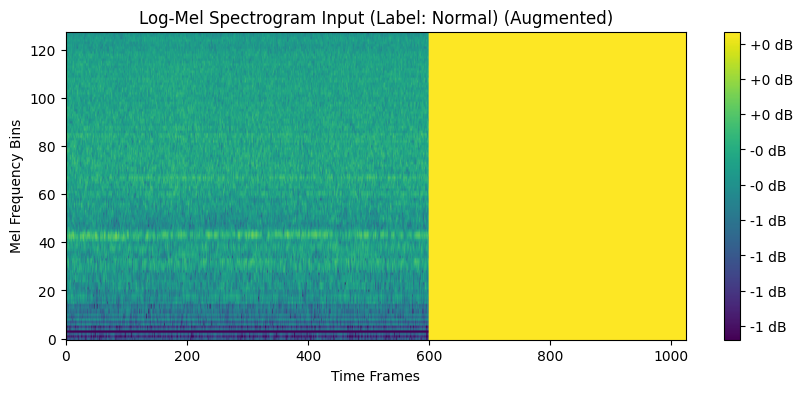

Visualizing Validation Sample #0 (Clean):

--- Spectrogram Analysis (Normal) (Clean) ---
Spectrogram shape: (128, 1024)
Spectrogram min: -1.2776, max: 0.4670
Spectrogram mean: -0.0059, std: 0.4217
Values in the last column (first 5 mel bins): [0.46703237 0.46703237 0.46703237 0.46703237 0.46703237]
Values in the last column (last 5 mel bins): [0.46703237 0.46703237 0.46703237 0.46703237 0.46703237]
---------------------------------------------------


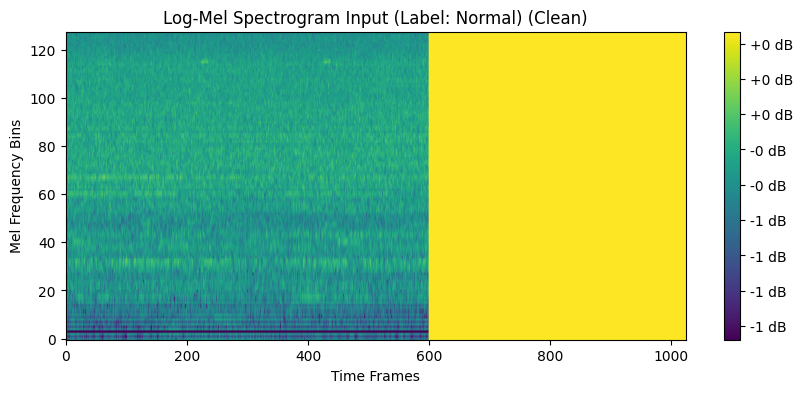

In [7]:
#Verify and Visualize Log-Mel Spectrograms
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported if not already

def plot_log_mel(tensor_data, label_id, title_suffix=""):

    spectrogram = tensor_data.T.numpy()

    # Debugging: Print stats of the spectrogram
    print(f"\n--- Spectrogram Analysis ({'Anomaly' if label_id==1 else 'Normal'}) {title_suffix} ---")
    print(f"Spectrogram shape: {spectrogram.shape}")
    print(f"Spectrogram min: {np.min(spectrogram):.4f}, max: {np.max(spectrogram):.4f}")
    print(f"Spectrogram mean: {np.mean(spectrogram):.4f}, std: {np.std(spectrogram):.4f}")
    if spectrogram.shape[1] > 1: # Check if there's at least one time frame
        print(f"Values in the last column (first 5 mel bins): {spectrogram[:5, -1]}")
        print(f"Values in the last column (last 5 mel bins): {spectrogram[-5:, -1]}")
    print("---------------------------------------------------")
    # End Debugging

    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"Log-Mel Spectrogram Input (Label: {'Anomaly' if label_id==1 else 'Normal'}) {title_suffix}")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency Bins")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Visualize a few samples from our processed lists
print("Visualizing Training Sample #0 (Augmented):")
plot_log_mel(train_X[0], train_y[0], "(Augmented)")

print("Visualizing Validation Sample #0 (Clean):")
plot_log_mel(test_X[0], test_y[0], "(Clean)")

In [8]:
#checking  the shape of the samples
print(train_X[0].shape)
print(test_X[0].shape)
print(Val_X[0].shape)

torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])


In [9]:
#Create Fast Dataset Object
class FastASTDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Trainer expects dictionary with 'input_values' and 'labels'
        return {
            "input_values": self.features[idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create objects using the data from Cell 4
train_dataset = FastASTDataset(train_X, train_y)
test_dataset = FastASTDataset(test_X, test_y)
val_dataset=FastASTDataset(Val_X,Val_y)


In [34]:
# Load Model & Freeze Body
model = ASTForAudioClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=2,                     # Binary Classification (Normal vs Anomaly)
    ignore_mismatched_sizes=True
)

# Map labels for readability in the UI later
model.config.id2label = {0: "NORMAL", 1: "ANOMALY"}
model.config.label2id = {"NORMAL": 0, "ANOMALY": 1}

# # --- SPEED HACK: FREEZE THE TRANSFORMER ---
# print("Freezing transformer layers to speed up training...")
# for param in model.audio_spectrogram_transformer.parameters():
#     param.requires_grad = False

# # Unfreeze ONLY the classifier (the decision head)
# for param in model.classifier.parameters():
#     param.requires_grad = True

for name, param in model.named_parameters():
    if "patch_embed" in name or "layer.0" in name or "layer.1" in name:
        param.requires_grad = False



Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00


In [35]:
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer

# Load the metric
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Configuration
training_args = TrainingArguments(
    output_dir="./ast_turbo_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    dataloader_num_workers=2, # Reduced to 2 as suggested by system warning
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
    report_to="none",
    bf16=True,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


In [38]:
from transformers import TrainerCallback
from tqdm.auto import tqdm
from transformers import TrainerCallback
from tqdm.auto import tqdm

class TqdmCallback(TrainerCallback):
    def __init__(self):
        self.pbar = None

    def on_train_begin(self, args, state, control, **kwargs):
        total_steps = state.max_steps if state.max_steps != 0 else (
            len(kwargs["train_dataloader"]) * args.num_train_epochs
        )

        self.pbar = tqdm(
            total=total_steps,
            desc="Training",
            bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} | {elapsed}<{remaining}",
            colour="cyan",
            leave=True
        )

    def on_step_end(self, args, state, control, **kwargs):
        if self.pbar is not None:
            self.pbar.update(1)

            if state.log_history:
                last_log = state.log_history[-1]

                loss = last_log.get("loss", None)
                lr = last_log.get("learning_rate", None)
                epoch = last_log.get("epoch", state.epoch)

                postfix = {}
                if loss is not None:
                    postfix["loss"] = f"{loss:.4f}"
                if lr is not None:
                    postfix["lr"] = f"{lr:.2e}"
                postfix["epoch"] = f"{epoch:.2f}"

                self.pbar.set_postfix(postfix)

    def on_epoch_end(self, args, state, control, **kwargs):


        if state.log_history and "eval_accuracy" in state.log_history[-1]:
            eval_acc = state.log_history[-1]["eval_accuracy"]
            self.pbar.set_postfix({ "eval_acc": f"{eval_acc:.4f}",
                                   "best_eval": "✓" if eval_acc == state.best_metric else ""})

    def on_train_end(self, args, state, control, **kwargs):
        if self.pbar:
            self.pbar.close()
        print(f"\nTraining finished! Best eval accuracy: {state.best_metric:.4f}")

# Add it to your existing trainer
trainer.add_callback(TqdmCallback())

In [39]:

trainer.train()

Training:   0%|          | 0/2430 | 00:00<?

Training:   0%|          | 0/2430 | 00:00<?

Training:   0%|          | 0/2430 | 00:00<?

Epoch,Training Loss,Validation Loss,Accuracy
1,0.764700,0.516386,0.867788
2,0.160700,0.205422,0.930288
3,0.140500,0.175129,0.950721


Epoch,Training Loss,Validation Loss,Accuracy
1,0.764700,0.516386,0.867788
2,0.160700,0.205422,0.930288
3,0.140500,0.175129,0.950721
4,0.169100,0.216425,0.956731
5,0.083600,0.181821,0.963942



Training finished! Best eval accuracy: 0.9639

Training finished! Best eval accuracy: 0.9639

Training finished! Best eval accuracy: 0.9639


TrainOutput(global_step=2430, training_loss=0.2608603359863101, metrics={'train_runtime': 7070.8249, 'train_samples_per_second': 2.747, 'train_steps_per_second': 0.344, 'total_flos': 1.3166816649412608e+18, 'train_loss': 0.2608603359863101, 'epoch': 5.0})

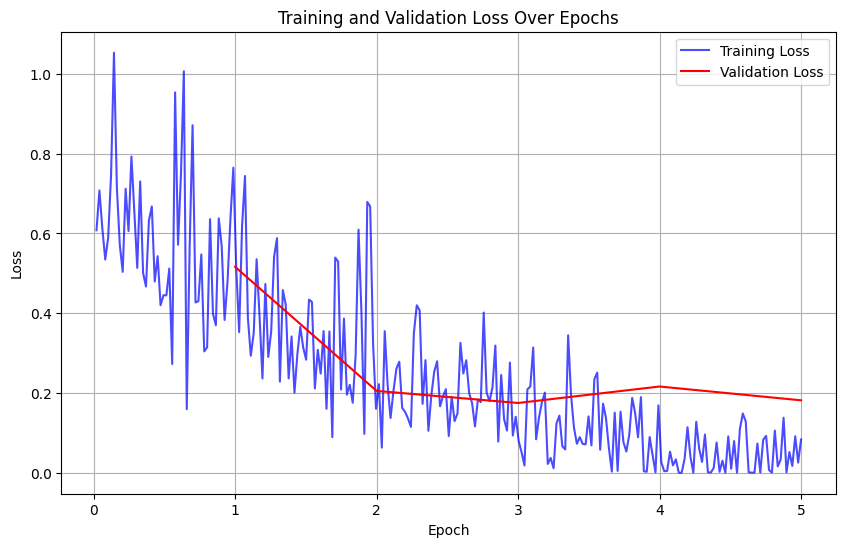

In [41]:
import matplotlib.pyplot as plt

# Extract training and validation loss from the trainer's log history
train_losses = []
val_losses = []
epochs = []

for log in trainer.state.log_history:
    if 'loss' in log: # Training loss
        train_losses.append(log['loss'])
        epochs.append(log['epoch'])
    if 'eval_loss' in log: # Validation loss
        val_losses.append(log['eval_loss'])


plt.figure(figsize=(10, 6))

# Plot training loss - use unique epochs from training logs
train_epochs = [log['epoch'] for log in trainer.state.log_history if 'loss' in log]
train_losses_plot = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
plt.plot(train_epochs, train_losses_plot, label='Training Loss', color='blue', alpha=0.7)

# Plot validation loss - use unique epochs from validation logs
val_epochs = [log['epoch'] for log in trainer.state.log_history if 'eval_loss' in log]
val_losses_plot = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
plt.plot(val_epochs, val_losses_plot, label='Validation Loss', color='red')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report,confusion_matrix
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)

# Extract predicted labels and true labels
predicted_labels = np.argmax(predictions.predictions, axis=1);
true_labels = predictions.label_ids

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(
    true_labels, predicted_labels, average='binary', pos_label=1
)

cl_rep=classification_report(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the results
print(f"\n--- Test Set Evaluation Results ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(cl_rep)
print("Confusion Matrix:")
print(conf_matrix)


--- Test Set Evaluation Results ---
Accuracy: 0.9508
Precision: 0.9245
Recall: 0.8869
F1 Score: 0.9053
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       612
           1       0.92      0.89      0.91       221

    accuracy                           0.95       833
   macro avg       0.94      0.93      0.94       833
weighted avg       0.95      0.95      0.95       833

Confusion Matrix:
[[596  16]
 [ 25 196]]


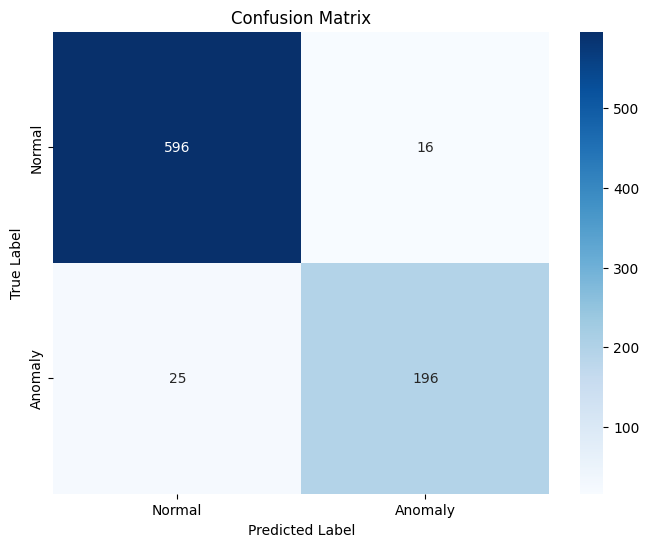

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [44]:
#trying it on pump set
import gdown
file_id = "19iNZZVT6MLdnMy54TZcM--Ci707-pw2f"

gdown.download(f"https://drive.google.com/uc?id={file_id}&confirm=t", output="data.zip", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=19iNZZVT6MLdnMy54TZcM--Ci707-pw2f&confirm=t
To: /content/data.zip



  0%|          | 0.00/1.09G [00:00<?, ?B/s]


  0%|          | 1.57M/1.09G [00:00<01:16, 14.2MB/s]


  1%|          | 8.91M/1.09G [00:00<00:31, 34.0MB/s]


  2%|▏         | 17.3M/1.09G [00:00<00:23, 46.4MB/s]


  2%|▏         | 23.1M/1.09G [00:00<00:21, 48.5MB/s]


  3%|▎         | 29.9M/1.09G [00:00<00:19, 54.3MB/s]


  3%|▎         | 35.7M/1.09G [00:00<00:22, 47.7MB/s]


  4%|▍         | 40.9M/1.09G [00:00<00:21, 48.1MB/s]


  4%|▍         | 46.7M/1.09G [00:01<00:26, 39.7MB/s]


  5%|▌         | 59.2M/1.09G [00:01<00:17, 59.9MB/s]


  6%|▌         | 66.6M/1.09G [00:01<00:31, 32.1MB/s]


  7%|▋         | 73.9M/1.09G [00:01<00:28, 35.5MB/s]


  8%|▊         | 83.4M/1.09G [00:01<00:22, 45.4MB/s]


  8%|▊         | 90.2M/1.09G [00:02<00:33, 29.8MB/s]


 10%|▉         | 105M/1.09G [00:02<00:21, 46.3MB/s] 


 10%|█         | 113M/1.09G [00:02<00:21, 45.4MB/s]


 11%|█   

'data.zip'

In [45]:
!unzip data.zip -d pump

Archive:  data.zip
   creating: pump/pump/test/
   creating: pump/pump/test/anomalous/
  inflating: pump/pump/test/anomalous/section_00_source_test_anomaly_0000.wav  
  inflating: pump/pump/test/anomalous/section_00_source_test_anomaly_0001.wav  
  inflating: pump/pump/test/anomalous/section_00_source_test_anomaly_0002.wav  
  inflating: pump/pump/test/anomalous/section_00_source_test_anomaly_0003.wav  
  inflating: pump/pump/test/anomalous/section_00_source_test_anomaly_0004.wav  
  inflating: pump/pump/test/anomalous/section_00_source_test_anomaly_0005.wav  
  inflating: pump/pump/test/anomalous/section_00_source_test_anomaly_0006.wav  
  inflating: pump/pump/test/anomalous/section_00_source_test_anomaly_0007.wav  
  inflating: pump/pump/test/anomalous/section_00_source_test_anomaly_0008.wav  
  inflating: pump/pump/test/anomalous/section_00_source_test_anomaly_0009.wav  
  inflating: pump/pump/test/anomalous/section_00_source_test_anomaly_0010.wav  
  inflating: pump/pump/test/anoma

Searching for files in the 'pump' directory...
Found 1200 files in the 'pump' dataset.

--- Processing PUMP Test Data (Clean) ---
Processing 1200 files... (Augmentation=OFF)
Processed 100...
Processed 200...
Processed 300...
Processed 400...
Processed 500...
Processed 600...
Processed 700...
Processed 800...
Processed 900...
Processed 1000...
Processed 1100...

--- Performing predictions on PUMP Test Data ---



--- PUMP Test Set Evaluation Results ---
Accuracy: 0.5308
Precision: 0.5228
Recall: 0.7083
F1 Score: 0.6016
              precision    recall  f1-score   support

           0       0.55      0.35      0.43       600
           1       0.52      0.71      0.60       600

    accuracy                           0.53      1200
   macro avg       0.54      0.53      0.52      1200
weighted avg       0.54      0.53      0.52      1200

Confusion Matrix for PUMP dataset:
[[212 388]
 [175 425]]


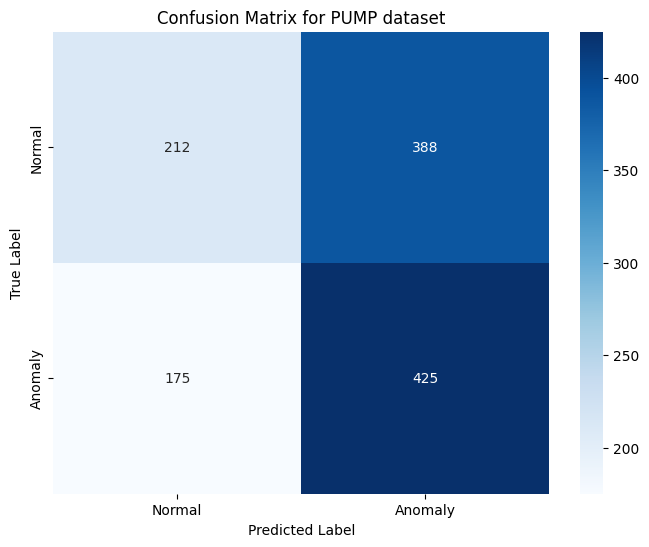

In [46]:
import os
from pathlib import Path

print("Searching for files in the 'pump' directory...")
pump_files = []
pump_labels = []

for root, dirs, files in os.walk("/content/pump/pump/test"):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            pump_files.append(path)
            # Label logic for pump dataset
            if "abnormal" in root.lower() or "anomalous" in root.lower():
                pump_labels.append(1)
            else:
                pump_labels.append(0)

print(f"Found {len(pump_files)} files in the 'pump' dataset.")

# Preprocess the new pump test data (without augmentation)
print("\n--- Processing PUMP Test Data (Clean) ---")
pump_X, pump_y = preprocess_set(pump_files, pump_labels, augment=False)

# Create a Dataset object for the pump data
pump_test_dataset = FastASTDataset(pump_X, pump_y)

# Perform prediction on the pump test dataset
print("\n--- Performing predictions on PUMP Test Data ---")
pump_predictions = trainer.predict(pump_test_dataset)

# Extract predicted labels and true labels for pump data
pump_predicted_labels = np.argmax(pump_predictions.predictions, axis=1)
pump_true_labels = pump_predictions.label_ids

# Calculate metrics for pump data
pump_accuracy = accuracy_score(pump_true_labels, pump_predicted_labels)
pump_precision, pump_recall, pump_f1_score, _ = precision_recall_fscore_support(
    pump_true_labels, pump_predicted_labels, average='binary', pos_label=1
)
pump_cl_rep = classification_report(pump_true_labels, pump_predicted_labels)
pump_conf_matrix = confusion_matrix(pump_true_labels, pump_predicted_labels)

# Print the results for pump data
print(f"\n--- PUMP Test Set Evaluation Results ---")
print(f"Accuracy: {pump_accuracy:.4f}")
print(f"Precision: {pump_precision:.4f}")
print(f"Recall: {pump_recall:.4f}")
print(f"F1 Score: {pump_f1_score:.4f}")
print(pump_cl_rep)
print("Confusion Matrix for PUMP dataset:")
print(pump_conf_matrix)

# Visualize the confusion matrix for pump data
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(pump_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for PUMP dataset')
plt.show()